In [ ]:
!pip install kaggle

Upload the json file got from kaggle.

In [ ]:
from google.colab import files
files.upload() #upload kaggle.json

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
from zipfile import ZipFile
file_name = "iamdatasethtrwords.zip"
with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('Done')

Done


In [ ]:
!pip install keras_tqdm

In [ ]:
import numpy as np
import cv2
import os
import pandas as pd
import string
import matplotlib.pyplot as plt

import os
from google.colab import drive #To use googel drive to get files.

from keras.preprocessing.sequence import pad_sequences

from keras.layers import Dense, LSTM, Reshape, BatchNormalization, Input, Conv2D, MaxPool2D, Lambda, Bidirectional
from keras.models import Model
from keras.activations import relu, sigmoid, softmax
import keras.backend as K
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from keras_tqdm import TQDMNotebookCallback

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [ ]:
import tensorflow as tf

#ignore warnings in the output
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

## **Tensorflow GPU**



In [ ]:
from tensorflow.python.client import device_lib

# Check all available devices if GPU is available
print(device_lib.list_local_devices())
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9749810754915277232
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 9493426825756151966
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 758257200347728616
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15701463552
locality {
  bus_id: 1
  links {
  }
}
incarnation: 5105019831887201603
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
]
Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capabi

In [ ]:
drive.mount('/content/gdrive')
with open('gdrive/My Drive/RMTC_Project/HTR_Using_CRNN/Data/words.txt') as f:
    contents = f.readlines()

lines = [line.strip() for line in contents]
lines[0]

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


'a01-000u-00-00 ok 154 408 768 27 51 AT A'

In [ ]:
max_label_len = 0

char_list = "!\"#&'()*+,-./0123456789:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz"

# string.ascii_letters + string.digits (Chars & Digits)
# or
# "!\"#&'()*+,-./0123456789:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz"

print(char_list, len(char_list))

def encode_to_labels(txt):
    # encoding each output word into digits
    dig_lst = []
    for index, chara in enumerate(txt):
        dig_lst.append(char_list.index(chara))

    return dig_lst

!"#&'()*+,-./0123456789:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz 78


In [ ]:
images = []
labels = []

RECORDS_COUNT = 10000

In [ ]:
train_images = []
train_labels = []
train_input_length = []
train_label_length = []
train_original_text = []

valid_images = []
valid_labels = []
valid_input_length = []
valid_label_length = []
valid_original_text = []

inputs_length = []
labels_length = []

In [ ]:
def process_image(img):
    """
    Converts image to shape (32, 128, 1) & normalize
    """
    w, h = img.shape

#     _, img = cv2.threshold(img,
#                            128,
#                            255,
#                            cv2.THRESH_BINARY | cv2.THRESH_OTSU)

    # Aspect Ratio Calculation
    new_w = 32
    new_h = int(h * (new_w / w))
    img = cv2.resize(img, (new_h, new_w))
    w, h = img.shape

    img = img.astype('float32')

    # Converts each to (32, 128, 1)
    if w < 32:
        add_zeros = np.full((32-w, h), 255)
        img = np.concatenate((img, add_zeros))
        w, h = img.shape

    if h < 128:
        add_zeros = np.full((w, 128-h), 255)
        img = np.concatenate((img, add_zeros), axis=1)
        w, h = img.shape

    if h > 128 or w > 32:
        dim = (128,32)
        img = cv2.resize(img, dim)

    img = cv2.subtract(255, img)

    img = np.expand_dims(img, axis=2)

    # Normalize
    img = img / 255

    return img

In [ ]:
for index, line in enumerate(lines):
    splits = line.split(' ')
    status = splits[1]

    if status == 'ok':
        word_id = splits[0]
        word = "".join(splits[8:])

        splits_id = word_id.split('-')
        filepath = 'words/{}/{}-{}/{}.png'.format(splits_id[0],
                                                  splits_id[0],
                                                  splits_id[1],
                                                  word_id)

        # processing on image
        img = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
        try:
            img = process_image(img)
        except:
            continue

        # processing on label
        try:
            label = encode_to_labels(word)
        except:
            continue

        if index % 10 == 0:
            valid_images.append(img)
            valid_labels.append(label)
            valid_input_length.append(31)
            valid_label_length.append(len(word))
            valid_original_text.append(word)
        else:
            train_images.append(img)
            train_labels.append(label)
            train_input_length.append(31)
            train_label_length.append(len(word))
            train_original_text.append(word)

        if len(word) > max_label_len:
            max_label_len = len(word)

    if index >= RECORDS_COUNT:
        break

In [ ]:
train_padded_label = pad_sequences(train_labels,
                             maxlen=max_label_len,
                             padding='post',
                             value=len(char_list))

valid_padded_label = pad_sequences(valid_labels,
                             maxlen=max_label_len,
                             padding='post',
                             value=len(char_list))

In [ ]:
train_padded_label.shape, valid_padded_label.shape

((7850, 16), (876, 16))

In [ ]:

train_images = np.asarray(train_images)
train_input_length = np.asarray(train_input_length)
train_label_length = np.asarray(train_label_length)

valid_images = np.asarray(valid_images)
valid_input_length = np.asarray(valid_input_length)
valid_label_length = np.asarray(valid_label_length)

In [ ]:
train_images.shape

(7850, 32, 128, 1)

In [ ]:
# input with shape of height=32 and width=128
inputs = Input(shape=(32,128,1))

# convolution layer with kernel size (3,3)
conv_1 = Conv2D(64, (3,3), activation = 'relu', padding='same')(inputs)
# poolig layer with kernel size (2,2)
pool_1 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_1)

conv_2 = Conv2D(128, (3,3), activation = 'relu', padding='same')(pool_1)
pool_2 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_2)

conv_3 = Conv2D(256, (3,3), activation = 'relu', padding='same')(pool_2)

conv_4 = Conv2D(256, (3,3), activation = 'relu', padding='same')(conv_3)

# poolig layer with kernel size (2,1)
pool_4 = MaxPool2D(pool_size=(2, 1))(conv_4)

conv_5 = Conv2D(512, (3,3), activation = 'relu', padding='same')(pool_4)

# Batch normalization layer
batch_norm_5 = BatchNormalization()(conv_5)

conv_6 = Conv2D(512, (3,3), activation = 'relu', padding='same')(batch_norm_5)
batch_norm_6 = BatchNormalization()(conv_6)
pool_6 = MaxPool2D(pool_size=(2, 1))(batch_norm_6)

conv_7 = Conv2D(512, (2,2), activation = 'relu')(pool_6)

squeezed = Lambda(lambda x: K.squeeze(x, 1))(conv_7)

# bidirectional LSTM layers with units=128
blstm_1 = Bidirectional(LSTM(256, return_sequences=True, dropout = 0.2))(squeezed)
blstm_2 = Bidirectional(LSTM(256, return_sequences=True, dropout = 0.2))(blstm_1)

outputs = Dense(len(char_list)+1, activation = 'softmax')(blstm_2)

# model to be used at test time
act_model = Model(inputs, outputs)

In [ ]:
act_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 128, 1)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 128, 64)       640       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 64, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 64, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 32, 128)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 32, 256)        295168    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 32, 256)        5900

In [ ]:
the_labels = Input(name='the_labels', shape=[max_label_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')

def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args

    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([outputs, the_labels, input_length, label_length])

#model to be used at training time
model = Model(inputs=[inputs, the_labels, input_length, label_length], outputs=loss_out)

In [ ]:
batch_size = 8
epochs = 30
e = str(epochs)
optimizer_name = 'sgd'

In [ ]:
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer = optimizer_name, metrics=['accuracy'])

filepath="gdrive/My Drive/RMTC_Project/HTR_Using_CRNN/Model/{}o-{}r-{}e-{}t-{}v.hdf5".format(optimizer_name,
                                          str(RECORDS_COUNT),
                                          str(epochs),
                                          str(train_images.shape[0]),
                                          str(valid_images.shape[0]))

checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
callbacks_list = [checkpoint]

In [ ]:
history = model.fit(x=[train_images, train_padded_label, train_input_length, train_label_length],
                    y=np.zeros(len(train_images)),
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=([valid_images, valid_padded_label, valid_input_length, valid_label_length], [np.zeros(len(valid_images))]),
                    verbose=2,
                    callbacks=callbacks_list)

Train on 7850 samples, validate on 876 samples
Epoch 1/30
 - 229s - loss: 15.7982 - accuracy: 0.0000e+00 - val_loss: 22.7894 - val_accuracy: 0.0000e+00

Epoch 00001: val_loss improved from inf to 22.78938, saving model to gdrive/My Drive/TcsInternship/parser/sgdo-10000r-30e-7850t-876v.hdf5
Epoch 2/30
 - 224s - loss: 13.4703 - accuracy: 0.0089 - val_loss: 12.8756 - val_accuracy: 0.0263

Epoch 00002: val_loss improved from 22.78938 to 12.87564, saving model to gdrive/My Drive/TcsInternship/parser/sgdo-10000r-30e-7850t-876v.hdf5
Epoch 3/30
 - 222s - loss: 11.9471 - accuracy: 0.0466 - val_loss: 11.9610 - val_accuracy: 0.0639

Epoch 00003: val_loss improved from 12.87564 to 11.96102, saving model to gdrive/My Drive/TcsInternship/parser/sgdo-10000r-30e-7850t-876v.hdf5
Epoch 4/30
 - 221s - loss: 10.4667 - accuracy: 0.0685 - val_loss: 16.7443 - val_accuracy: 0.0674

Epoch 00004: val_loss did not improve from 11.96102
Epoch 5/30
 - 217s - loss: 8.9951 - accuracy: 0.1096 - val_loss: 13.5724 - va

**Prediction.**

original_text =   the
predicted text = the

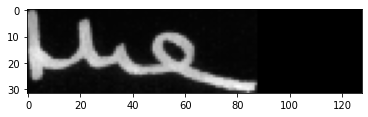



original_text =   Colonial
predicted text = Colonial

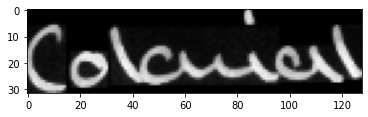



original_text =   Secretary
predicted text = Secretary

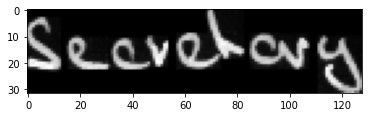



original_text =   ,
predicted text = ,

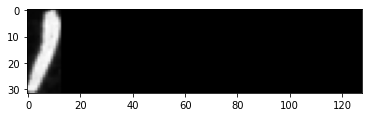



original_text =   Mr.
predicted text = Mr.

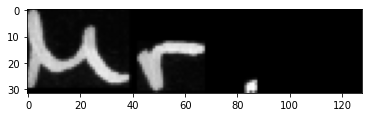



original_text =   Iain
predicted text = Iain

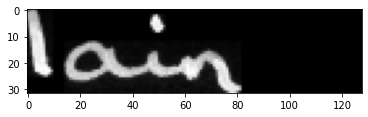



original_text =   Macleod
predicted text = Macleod

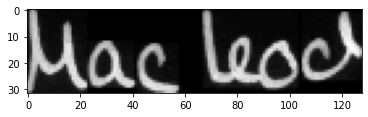



original_text =   is
predicted text = is

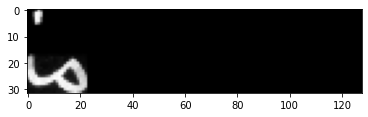



original_text =   insisting
predicted text = insisting

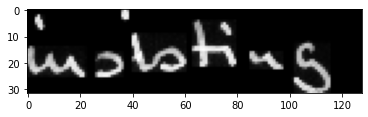



original_text =   on
predicted text = on

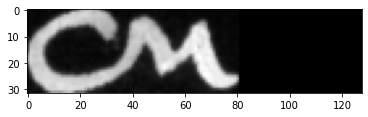



original_text =   a
predicted text = a

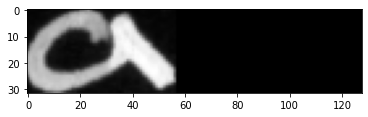



original_text =   policy
predicted text = policy

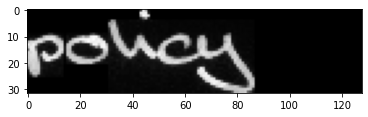



original_text =   of
predicted text = of

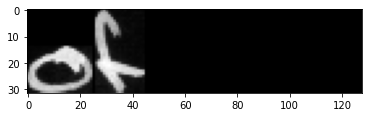



original_text =   change
predicted text = change

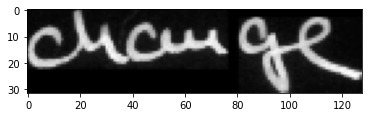



original_text =   .
predicted text = .

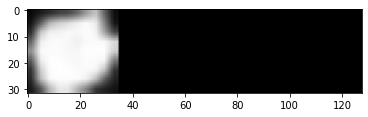



original_text =   Macleod
predicted text = Macleod

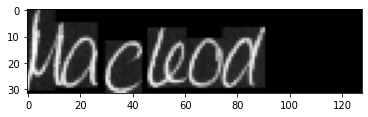



original_text =   ,
predicted text = ,

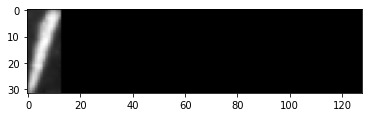



original_text =   is
predicted text = is

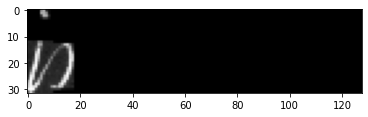



original_text =   on
predicted text = on

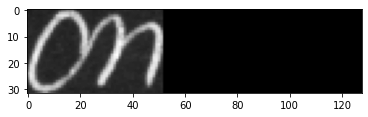



original_text =   a
predicted text = a

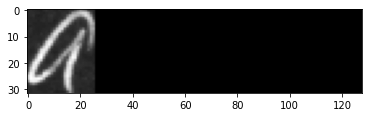



original_text =   policy
predicted text = policy

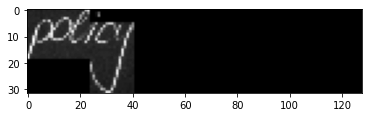



original_text =   of
predicted text = of

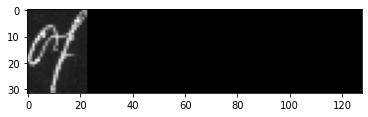



original_text =   change
predicted text = change

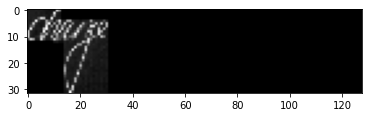



original_text =   .
predicted text = .

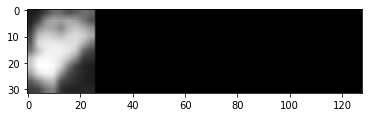



original_text =   Sir
predicted text = Sir

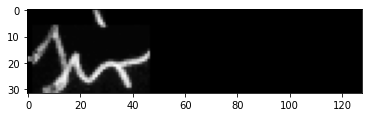



original_text =   Roy's
predicted text = Roy's

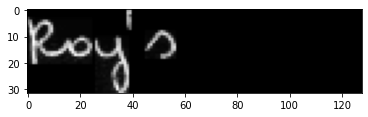



original_text =   United
predicted text = United

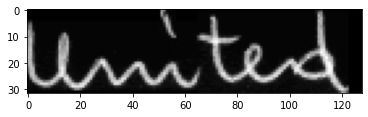



original_text =   Party
predicted text = Party

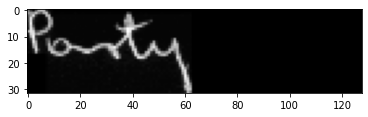



original_text =   is
predicted text = is

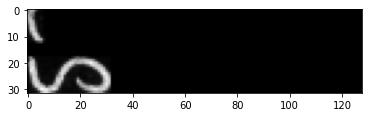



original_text =   boycotting
predicted text = boycotting

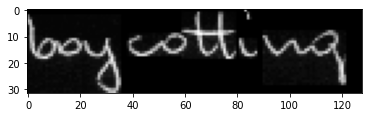



original_text =   the
predicted text = the

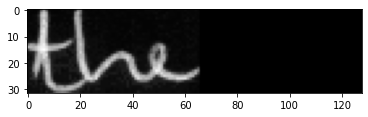



original_text =   London
predicted text = London

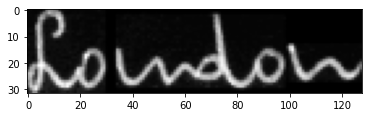



original_text =   talks
predicted text = talks

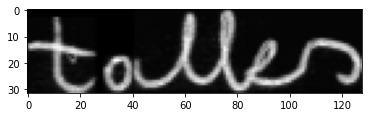



original_text =   on
predicted text = on

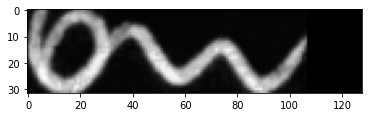



original_text =   the
predicted text = the

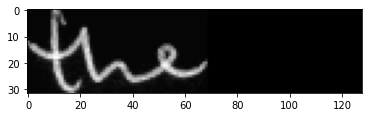



original_text =   Protectorate's
predicted text = Protectorate's

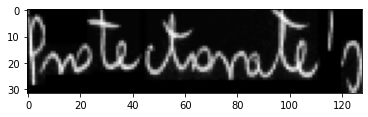



original_text =   .
predicted text = .

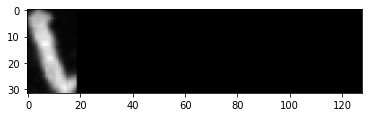



original_text =   Said
predicted text = Said

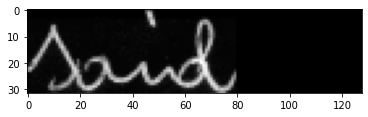



original_text =   Mr.
predicted text = Mr.

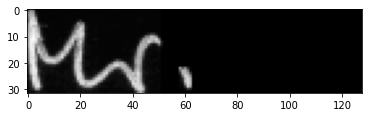



original_text =   Nkumbula
predicted text = Nkumbula

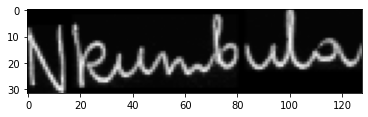



original_text =   last
predicted text = last

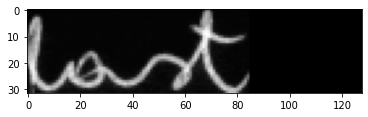



original_text =   night
predicted text = night

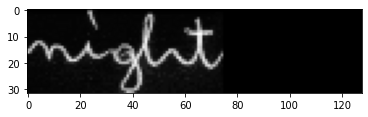



original_text =   :
predicted text = :

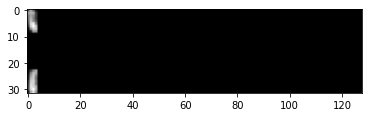



original_text =   "
predicted text = "

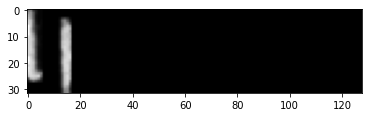



original_text =   We
predicted text = We

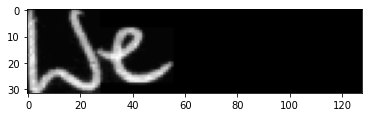



original_text =   to
predicted text = to

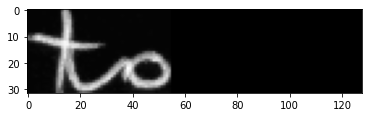



original_text =   discuss
predicted text = discuss

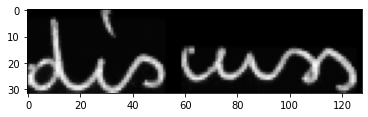



original_text =   what
predicted text = what

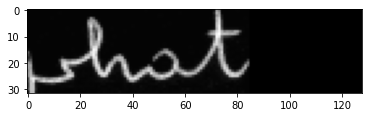



original_text =   to
predicted text = to

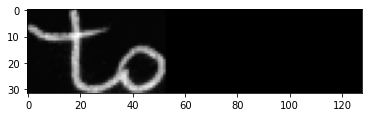



original_text =   do
predicted text = do

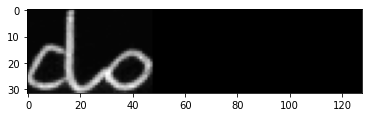



original_text =   if
predicted text = if

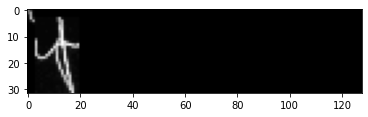



original_text =   the
predicted text = the

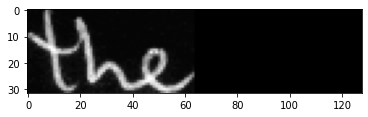



original_text =   British
predicted text = British

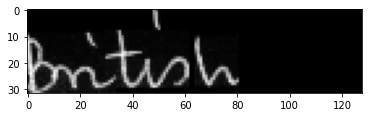



original_text =   Government
predicted text = Government

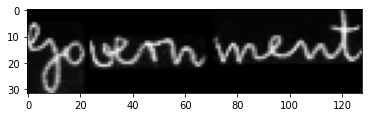



original_text =   in
predicted text = in

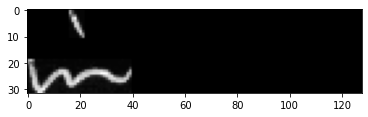



original_text =   to
predicted text = to

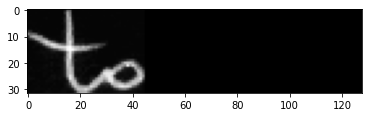



original_text =   Sir
predicted text = Sir

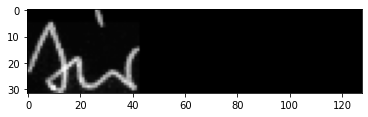



original_text =   Roy
predicted text = Roy

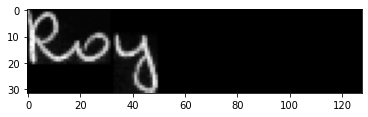



original_text =   and
predicted text = and

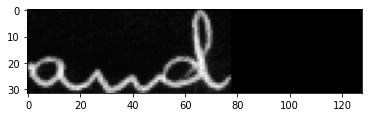



original_text =   the
predicted text = the

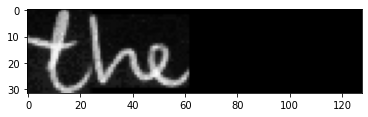



original_text =   talks
predicted text = talks

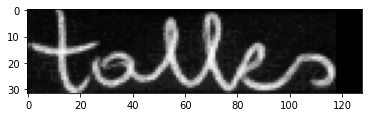



original_text =   fall
predicted text = fall

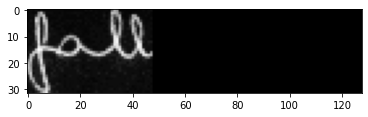



original_text =   through
predicted text = through

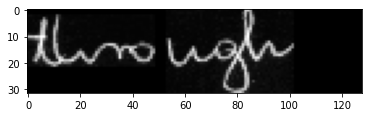



original_text =   There
predicted text = There

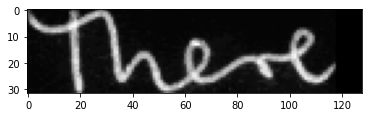



original_text =   are
predicted text = are

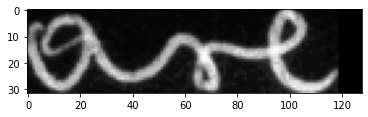



original_text =   bound
predicted text = bound

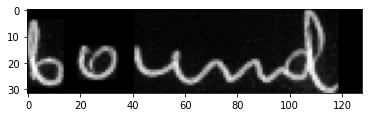



original_text =   chief
predicted text = chief

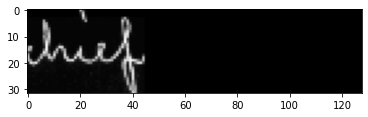



original_text =   aide
predicted text = aide

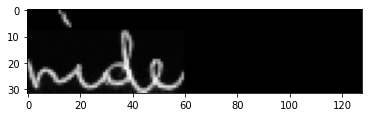



original_text =   ,
predicted text = ,

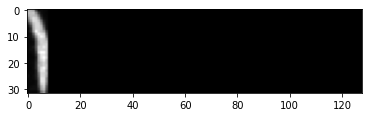



original_text =   Mr.
predicted text = Mr.

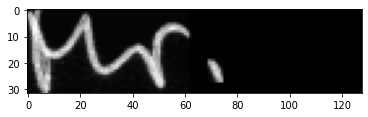



original_text =   Julius
predicted text = Julius

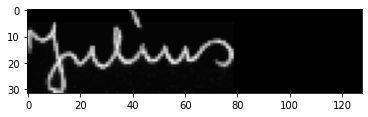



original_text =   Greenfield
predicted text = Geenfield

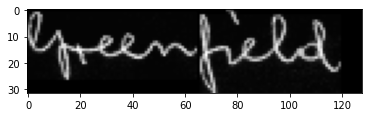



original_text =   ,
predicted text = ,

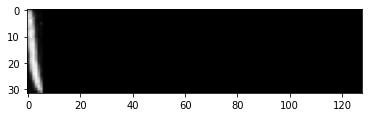



original_text =   telephoned
predicted text = telephoned

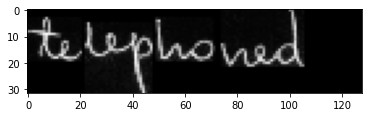



original_text =   chief
predicted text = chief

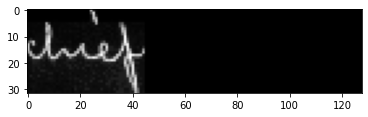



original_text =   a
predicted text = a

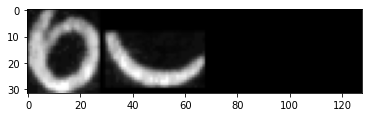



original_text =   report
predicted text = report

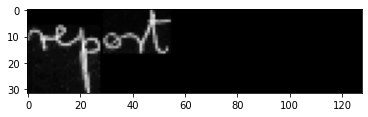



original_text =   on
predicted text = on

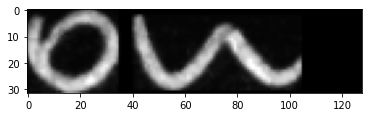



original_text =   his
predicted text = his

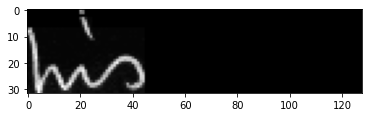



original_text =   talks
predicted text = tals

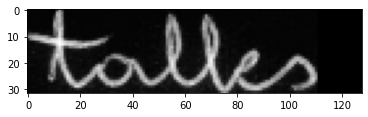



original_text =   with
predicted text = with

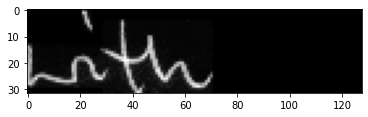



original_text =   Mr.
predicted text = Mr.

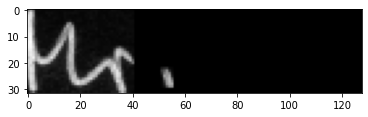



original_text =   Macmillan
predicted text = Macmillan

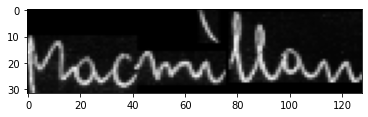



original_text =   Chequers
predicted text = Cheqhuers

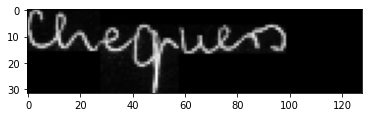



original_text =   .
predicted text = .

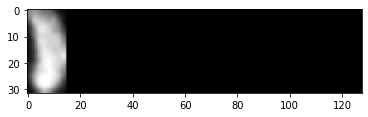



original_text =   Sir
predicted text = Sir

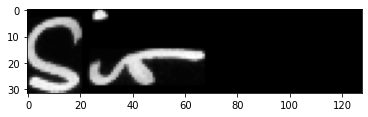



original_text =   Roy's
predicted text = Roy's

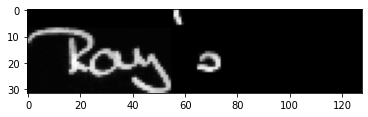



original_text =   United
predicted text = United

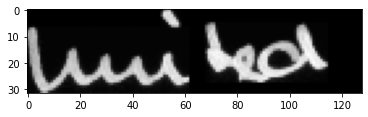



original_text =   Federal
predicted text = Federal

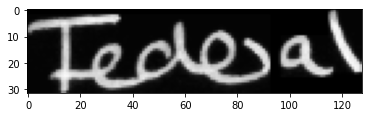



original_text =   Party
predicted text = Party

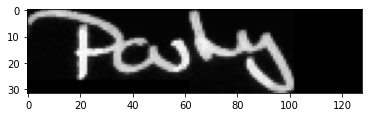



original_text =   is
predicted text = is

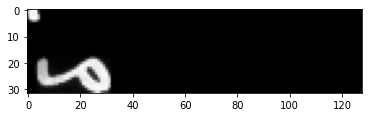



original_text =   boycotting
predicted text = boycotting

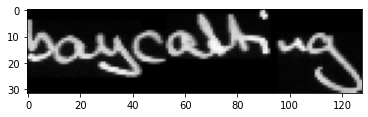



original_text =   London
predicted text = London

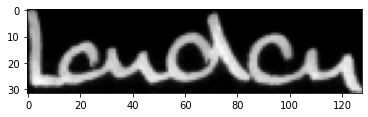



original_text =   talks
predicted text = talks

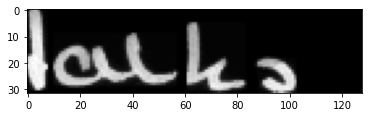



original_text =   on
predicted text = on

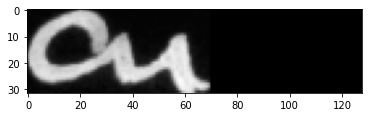



original_text =   the
predicted text = the

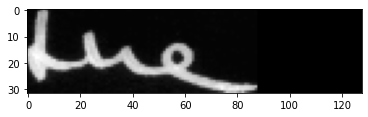



original_text =   last
predicted text = last

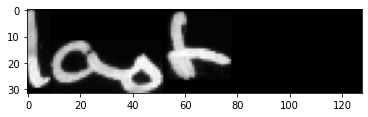



original_text =   night
predicted text = night

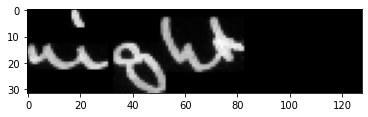



original_text =   :
predicted text = :

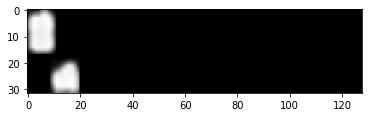



original_text =   "
predicted text = "

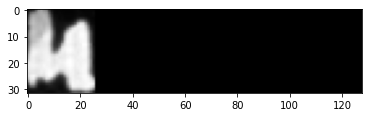



original_text =   We
predicted text = We

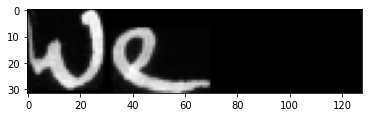



original_text =   want
predicted text = want

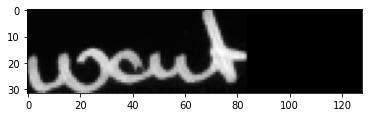



original_text =   to
predicted text = to

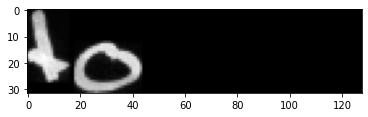

In [ ]:
# predict outputs on validation images
prediction =act_model.predict(train_images[542:645])

# use CTC decoder
decoded = K.ctc_decode(prediction,
                       input_length=np.ones(prediction.shape[0]) * prediction.shape[1],
                       greedy=True)[0][0]

out = K.get_value(decoded)

# see the results
for i, x in enumerate(out):
    print("original_text =  ", train_original_text[542+i])
    print("predicted text = ", end = '')
    for p in x:
        if int(p) != -1:
            print(char_list[int(p)], end = '')
    plt.imshow(train_images[542+i].reshape(32,128), cmap=plt.cm.gray)
    plt.show()
    print('\n')

## **Plot Accuracy and Loss**

In [ ]:
def plotgraph(epochs, acc, val_acc):
    # Plot training & validation accuracy values
    plt.plot(epochs, acc, 'b')
    plt.plot(epochs, val_acc, 'r')
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

In [ ]:

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1,len(loss)+1)

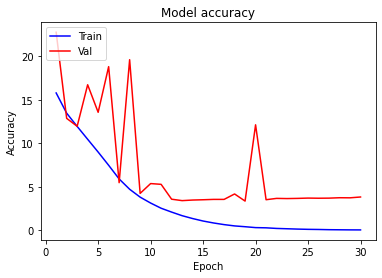

In [ ]:
plotgraph(epochs, loss, val_loss)

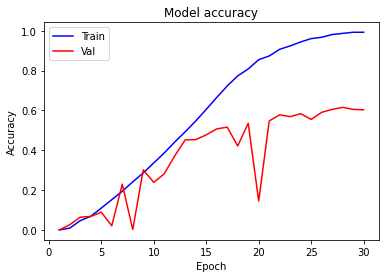

In [ ]:
plotgraph(epochs, acc, val_acc)